# Keras based GRU Network

## Prepare dataset

Reformat dataset to be int format
```
caption | valence_class
caption | {negative,neutral,positive}
```

In [1]:
import os, sys, io,re, string, pathlib, random
from collections import Counter, OrderedDict

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.caption_utils as caput
import hecutils.image_utils as imut


import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Bidirectional, LSTM
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
from keras.preprocessing import text

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, train_test_split

import numpy as np
import pandas as pd


from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
import time

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

None


Using TensorFlow backend.


## Set Keras to use Tensorflow GPU in the backend

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

## Global variables

In [15]:
# fix random seed for reproducibility
seed = 7

oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
captions_root_path = pathlib.Path(captions_root)
human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
model_results_root_dir = "model/"
inputDataset_csv_path = captions_root_path/"inputDataset.csv"
testDataset_csv_path = captions_root_path/"testDataset.csv"

neutralLow = 3.0 
neutralHigh = 5.0

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'


dataset_path = human_output_caption_to_label_csv_path
# dataset_path = auto_output_caption_to_label_csv_path

kfold_splits = 7 # 5 # 10 # 7 
test_size = 0.1

embedding_dimension = 300
hidden_layer_dim = 32
batch_size = 64
nb_epochs = 100
dropout = 0.3
recurrent_dropout=0.3
patience = 10
verbose = 0

useF1Score = True

## Create <caption,label> CSV files

In [16]:
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

## Divide data into train/val/test datasets

In [17]:
df = pd.read_csv(dataset_path, header=0, sep="|")
df["caption"] = df["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
df["label"] = df["label"].apply(lambda x: caput.change_label_str_to_int(x))



input_x, test_x, input_y,  test_y = train_test_split(df["caption"],
                                                     df["label"],
                                                     test_size=test_size,
                                                     random_state=seed,
                                                     stratify=df["label"])

inputDataset = pd.concat([input_x, input_y], axis=1)
testDataset = pd.concat([test_x, test_y], axis=1)

inputDataset = inputDataset.dropna()
testDataset = testDataset.dropna()
inputDataset = inputDataset.reset_index()
testDataset = testDataset.reset_index()


inputDataset.to_csv(inputDataset_csv_path, index=False, sep="|")
testDataset.to_csv(testDataset_csv_path, index=False, sep="|")

print("df.head()\n", df.head())
print("inputDataset.head()\n", inputDataset.head())
print("testDataset.head()\n", testDataset.head())
print("\n")
print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
print("Label distribution in testDataset", testDataset.groupby('label').label.count())

df.head()
   imageId                                            caption  label
0      I1           two acorns lying ground next oak leaves.      0
1      I2  three acorns flat surface. one acorn missing c...      0
2      I3  five acorns arranged circle black background. ...      0
3      I4  two cocktails brown wooden table. cocktail fro...      0
4      I5                three shelves full bottles whiskey.      0
inputDataset.head()
    index                                            caption  label
0    723                    two sea lions face open mouths.      0
1    751  empty lighted ski run twilight spectators watc...      0
2    309                        pile dog feces lying grass.     -1
3    104  group young students classroom knees hands fol...      0
4    446         close-up computer keyboard. layout german.      0
testDataset.head()
    index                                            caption  label
0    340  flooded river flowing bridge carrying vehicula...     -1
1   

## Loading Fasttext Embeddings

You can download fasttext word vectors from here:

https://fasttext.cc/docs/en/english-vectors.html    
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
    

In [6]:
def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}
wordToVec = load_embedding(fasttext_embedding_path)



embedding size : 999995
embedding dimension : (300,)


## Results

Epoch 300/300
663/663 [==============================] - 2s 3ms/step - loss: 0.1011 - acc: 0.9789 - val_loss: 1.9239 - val_acc: 0.6426

best_val_acc:  0.7148936180358237
filename adidas-0.7149-1527322080
Total time passed for training 9.198103360335033


config:
 {'kfold_splits': 7, 'batch_size': 64, 'embedding_dimension': 300, 'recurrent_dropout': 0.3, 'dropout': 0.3, 'nb_epochs': 100, 'useF1Score': True, 'verbose': 0}
# words:  999995  word vector dimension 300
Label distribution:  label
-1    147
 0    378
 1    285
Name: label, dtype: int64
max_seq_len 38

TRAIN size: 694 	 VAL size: 116
Train label distribution:  label
-1    123
 0    327
 1    244
Name: label, dtype: int64
Val label distribution:  label
-1    24
 0    51
 1    41
Name: label, dtype: int64
best_val_acc:  0.6896551683031279
best_f1:  0.6667033105060972
best_train_acc 0.8515850157833924
best_val_acc 0.6896551683031279
best_f1 0.6667033105060972
best_train_f1 0.8453400768876419


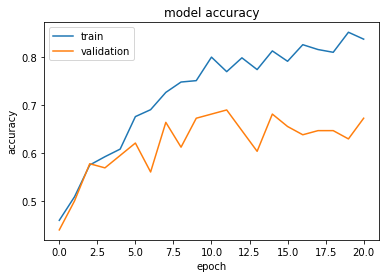

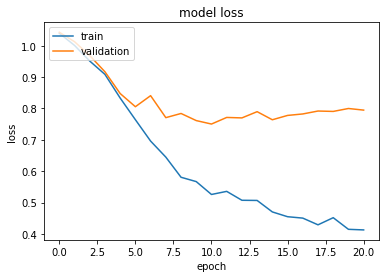

Time passed for training 61.73190712928772

TRAIN size: 694 	 VAL size: 116
Train label distribution:  label
-1    132
 0    313
 1    249
Name: label, dtype: int64
Val label distribution:  label
-1    15
 0    65
 1    36
Name: label, dtype: int64
best_val_acc:  0.7413792980128321
best_f1:  0.7348026592155983
best_train_acc 0.8400576382617786
best_val_acc 0.7413792980128321
best_f1 0.7348026592155983
best_train_f1 0.839290208878366


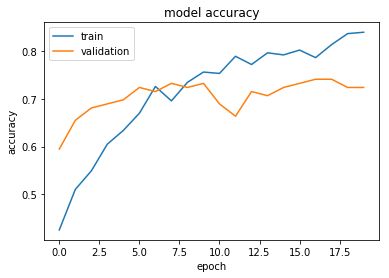

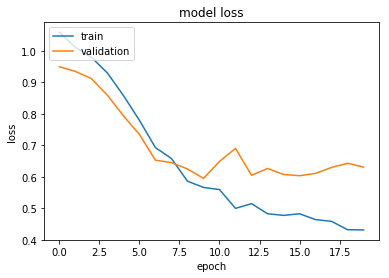

Time passed for training 63.50437927246094

TRAIN size: 694 	 VAL size: 116
Train label distribution:  label
-1    129
 0    322
 1    243
Name: label, dtype: int64
Val label distribution:  label
-1    18
 0    56
 1    42
Name: label, dtype: int64
best_val_acc:  0.7327586289109855
best_f1:  0.7257736880203773
best_train_acc 0.8342939503598282
best_val_acc 0.7327586289109855
best_f1 0.7257736880203773
best_train_f1 0.8259083510132276


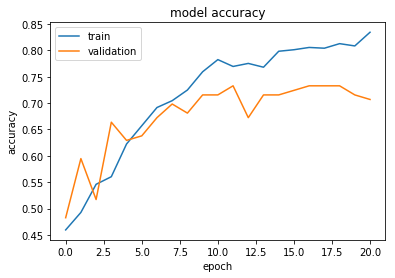

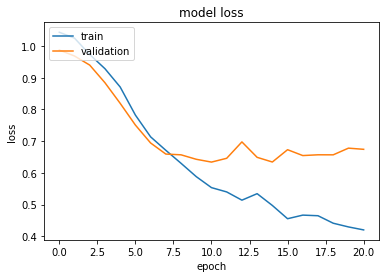

Time passed for training 67.52042865753174

TRAIN size: 694 	 VAL size: 116
Train label distribution:  label
-1    123
 0    319
 1    252
Name: label, dtype: int64
Val label distribution:  label
-1    24
 0    59
 1    33
Name: label, dtype: int64
best_val_acc:  0.6724137889927831
best_f1:  0.6339297664576563
best_train_acc 0.8357348687710611
best_val_acc 0.6724137889927831
best_f1 0.6339297664576563
best_train_f1 0.832113555254098


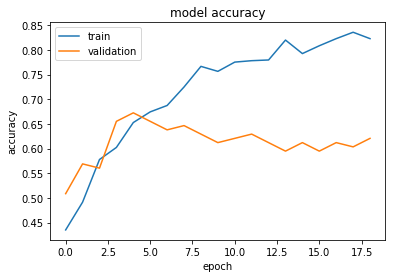

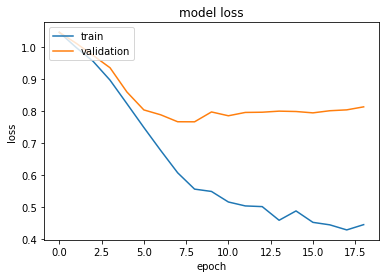

Time passed for training 65.49555730819702

TRAIN size: 694 	 VAL size: 116
Train label distribution:  label
-1    127
 0    323
 1    244
Name: label, dtype: int64
Val label distribution:  label
-1    20
 0    55
 1    41
Name: label, dtype: int64
best_val_acc:  0.7500000061659977
best_f1:  0.716656769144124
best_train_acc 0.8342939482985725
best_val_acc 0.7500000061659977
best_f1 0.716656769144124
best_train_f1 0.8310923736102299


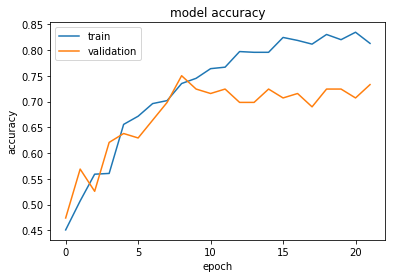

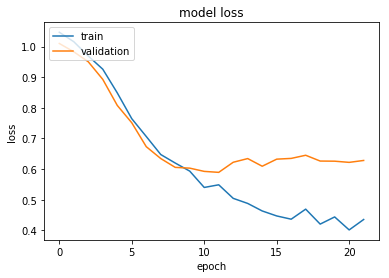

Time passed for training 67.87051391601562

TRAIN size: 695 	 VAL size: 115
Train label distribution:  label
-1    123
 0    340
 1    232
Name: label, dtype: int64
Val label distribution:  label
-1    24
 0    38
 1    53
Name: label, dtype: int64
best_val_acc:  0.6521739228912021
best_f1:  0.6395396999690843
best_train_acc 0.8417266210206121
best_val_acc 0.6521739228912021
best_f1 0.6395396999690843
best_train_f1 0.8288036517959705


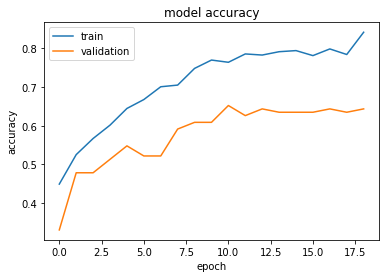

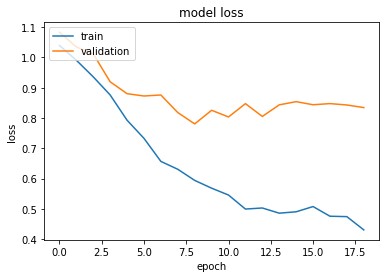

Time passed for training 59.69159150123596

TRAIN size: 695 	 VAL size: 115
Train label distribution:  label
-1    125
 0    324
 1    246
Name: label, dtype: int64
Val label distribution:  label
-1    22
 0    54
 1    39
Name: label, dtype: int64
best_val_acc:  0.773913047624671
best_f1:  0.7632707730583522
best_train_acc 0.8402877707275556
best_val_acc 0.773913047624671
best_f1 0.7632707730583522
best_train_f1 0.840875631613697


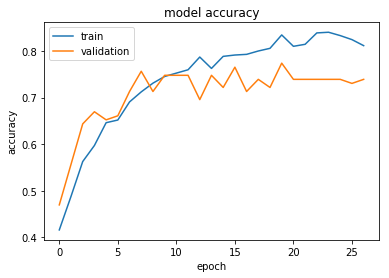

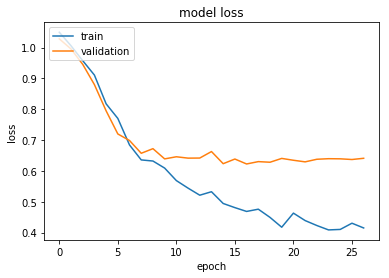

Time passed for training 75.49012994766235
Cross-validation val accuracy results:  [0.6896551683031279, 0.7413792980128321, 0.7327586289109855, 0.6724137889927831, 0.7500000061659977, 0.6521739228912021, 0.773913047624671]
Cross-validation val accuracy results: 0.72% (+/- 0.04%)

 Cross-validation val f1 results:  [0.6667033105060972, 0.7348026592155983, 0.7257736880203773, 0.6339297664576563, 0.716656769144124, 0.6395396999690843, 0.7632707730583522]
Cross-validation val f1 results: 0.70% (+/- 0.05%)
max_seq_len 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_36 (Masking)         (None, None, 300)         0         
_________________________________________________________________
bidirectional_71 (Bidirectio (None, None, 76)          77292     
_________________________________________________________________
bidirectional_72 (Bidirectio (None, 76)                26220     
________________

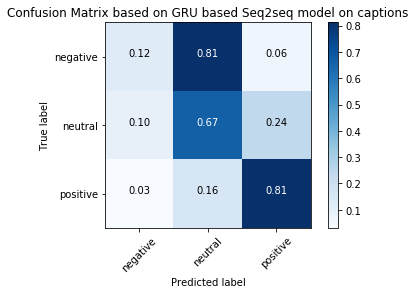

flooded river flowing bridge carrying vehicular traffic. flood waters partially covered road surrounded tree. TL -1 PL 0
man sitting chair head tilted back eyes open gazing something above. TL 0 PL 1
man kneeling front tent two similar-looking girls sides. hands rest shoulder, one top other. TL 1 PL 0
orangutan flabby cheeks watching something intently TL 0 PL 1
dark silhouettes different types guns, rifles grenade. TL -1 PL 0
two people walking bridge body water. water risen high level partially covering street signs bridge. pieces plant matter floating water. TL -1 PL 0
two students hunched desk working problem together students work background. TL 1 PL 0
little dog bows hair lying muzzle carpet. TL 0 PL 1
six hands resting other. one wrists purple band around it. another one white watch. TL 1 PL 0
young boys working factory TL -1 PL 1
pregnant woman hands exposed abdomen. TL 1 PL -1
sunset small cemetery. TL 0 PL 1
brown cockroach spiky legs flat surface TL -1 PL 0
iron bars across 

In [18]:
def build_model(max_seq_len, num_of_classes, config): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, config['embedding_dimension'])))
    #model.add(GRU(max_seq_len,return_sequences=True, recurrent_dropout=recurrent_dropout))
    #model.add(GRU(max_seq_len, dropout=0.65, recurrent_dropout=0.35))
    model.add(Bidirectional(GRU(max_seq_len, return_sequences=True, dropout=config['dropout'],
                                recurrent_dropout=config['recurrent_dropout']), merge_mode='concat'))
    model.add(Bidirectional(GRU(max_seq_len, dropout=config['dropout'] - 0.1, 
                                recurrent_dropout=config['recurrent_dropout'] - 0.1 ), merge_mode='concat'))    
    model.add(Dense(num_of_classes, activation='softmax'))
    
    if config['useF1Score']:
        metrics = ['accuracy', sc.f1, sc.recall, sc.precision]
    else:
        metrics = ['accuracy']
        

    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=metrics)
    #print(model.summary())
    return model


def evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, config):
    max_seq_len = int(testDataset['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    num_of_classes, class_to_index, index_to_class = caput.get_label_map_from_train_set(inputDataset, wordToVec, max_seq_len, config)
    X_test, y_test_index, _, _, _  = caput.load_dataset_StratifiedKFold(testDataset,wordToVec,max_seq_len,class_to_index, index_to_class, config)
    y_test = caput.convert_index_to_one_hot(y_test_index, num_of_classes) 
    print(model.summary())
    results = model.evaluate(X_test, y_test, verbose=1) # batch_size=1,
    print(model.metrics_names, results)
        
    predictions = model.predict(X_test, verbose=1)    
    predictionClasses = imut.conver_predictions_to_classes(predictions, class_to_index)
    y_test_classes = [index_to_class[k] for k in y_test_index]
    y_true = y_test_classes
    y_pred = predictionClasses
    
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on GRU based Seq2seq model on captions"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    misLabeledCount = 0
    for index, row in testDataset.iterrows():
        caption = row['caption']
        label = row['label']
        if label != y_true[index]:
            print(caption)
            raise "Unexpected result, truth labels should have matched, seems the order is messed up"
        if label != y_pred[index]:
            print(caption,"TL", label,"PL", y_pred[index])
            misLabeledCount += 1 
    print("\n")
    print("Mislabeled count: ", misLabeledCount)


def train_StratifiedKFold(inputDataset, testDataset, wordToVec, config):
    """StratifiedKFold cross-validation"""
    # Shuffle dataset
    df = shuffle(inputDataset)
    X = df["caption"]
    y = df["label"]
    print("Label distribution: ",df.groupby('label').label.count())
    max_seq_len = int(df['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    cv_accuracies = []
    cv_f1s = []
    
    best_model = None
    best_model_best_acc = -1
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        start = time.time()        
        class_to_index = {}
        index_to_class = {}
        
        X_train, X_val = X[train_indices], X[val_indices]
        y_train_index, y_val_index = y[train_indices], y[val_indices]
        
        dfTrain = pd.concat([X_train, y_train_index], axis=1)
        dfTrain.columns = ['caption', 'label']
        X_train, y_train_index, num_of_classes, class_to_index, index_to_class = \
            caput.load_dataset_StratifiedKFold(
                            dfTrain,
                            wordToVec, 
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_train = caput.convert_index_to_one_hot(y_train_index, num_of_classes) 
        
        dfVal= pd.concat([X_val, y_val_index], axis=1)
        dfVal.columns = ['caption', 'label']
        X_val, y_val_index, _, _, _ = caput.load_dataset_StratifiedKFold(
                            dfVal,
                            wordToVec,
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_val = caput.convert_index_to_one_hot(y_val_index, num_of_classes) 
        
        
        print("\nTRAIN size:", len(train_indices), "\t VAL size:", len(val_indices))
        print("Train label distribution: ",dfTrain.groupby('label').label.count())
        print("Val label distribution: ",dfVal.groupby('label').label.count())

        
        model = build_model(max_seq_len,
                            num_of_classes, 
                            config
                            )
        plot_model(model, to_file = model_results_root_dir + '/model.png', show_shapes=True, show_layer_names=True)#
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.7, 
                                  patience=2, 
                                  min_lr=10e-7,
                                  cooldown=1,
                                  verbose=config['verbose'])
        
        history = {}
        filename = ""
        # checkpoint
        filepath= model_results_root_dir + "/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        
        callbacks_list = [checkpoint,  reduce_lr, early_stopping]  # 
        history = model.fit(x=X_train,
                      y=y_train, 
                      batch_size=config['batch_size'],
                      epochs=config['nb_epochs'], 
                      verbose=config['verbose'], 
                      validation_data = (X_val, y_val),
                      shuffle=True,
                      callbacks=callbacks_list)        
        val_acc_list = history.history['val_acc']
        best_val_acc =  max(val_acc_list)
        cv_accuracies.append(best_val_acc)
        print("best_val_acc: ", best_val_acc)
        
        if config['useF1Score']:
            val_f1_list = history.history['val_f1']
            best_f1 =  max(val_f1_list)
            print("best_f1: ", best_f1)
            cv_f1s.append(best_f1)
        
        filename = "caption" 
        filename = model_results_root_dir + caput.generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        
        pt.plot_model_accuracy(history,model_results_root_dir, config['useF1Score'])
        
        end = time.time()
        print("Time passed for training", (end-start))
        
        if best_val_acc > best_model_best_acc:
            best_model_best_acc = best_val_acc
            best_model = model
    
    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    best_model.save(model_results_root_dir + "/bestmodel-" + str(best_model_best_acc) + ".h5")
    return best_model


def get_config():
    conf = {}
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf['embedding_dimension'] = embedding_dimension
    conf['recurrent_dropout'] = recurrent_dropout
    conf['dropout'] = dropout
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    conf['useF1Score'] = useF1Score
    return conf    
    
best_model = None
def main():
    global wordToVec, best_model
    config = get_config()
    print("config:\n", config)
    if wordToVec is None:
        wordToVec = load_embedding(fasttext_embedding_path)
    print("# words: ", len(wordToVec.keys())," word vector dimension", len(wordToVec[list(wordToVec.keys())[1]]))
    best_model = train_StratifiedKFold(inputDataset, testDataset, wordToVec, config)
    # Evaluate Test data set
    evalaute_on_test_data(best_model, testDataset, inputDataset, wordToVec, config)
    pass

if __name__ == "__main__":
    # execute only if run as a script
    main()

In [ ]:

        
        

evalaute_on_test_data(best_model, testDataset, inputDataset,wordToVec, get_config())

## Determien Vocabulary size - unique word counts

In [ ]:
df = pd.read_csv(dataset_path, header=0, sep="|")
df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
vocabulary = set()
for index, row in df.iterrows():
    caption = row['caption']
    words = caption.lower().split()
    for word in words:
        vocabulary.add(word)
    
print("Voc size: ",len(vocabulary))    

# New Train on Twitter dataset, validate on OASIS images caption dataset

1,578,628 Tweets with positive/negative sentiments - labelled data

In [ ]:
# %matplotlib inline
# import os, sys
# import re
# import string
# import pathlib
# import random
# from collections import Counter, OrderedDict
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import spacy
# from tqdm import tqdm, tqdm_notebook, tnrange
# tqdm.pandas(desc='Progress')

# from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
# from sklearn.metrics import accuracy_score

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'

# import warnings
# warnings.filterwarnings('ignore')



In [ ]:
# nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
# def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

# def tweet_clean(text):
#     text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
#     text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
#     return text.strip()


# twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Sentiment_Analysis_Dataset.csv" 
# cleaned_twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Cleaned_Sentiment_Analysis_Dataset.csv" 
# df = pd.read_csv(twitter_dataset_path, error_bad_lines=False)
# df = df[['SentimentText','Sentiment']]
# df["SentimentText"] = df["SentimentText"].apply(lambda x: tokenizer(x))
# df["SentimentText"] = df["SentimentText"].apply(lambda x: " ".join(x))
# df["SentimentText"] = df["SentimentText"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
# df.columns = ['caption','label']
# df = df.dropna()
# df.to_csv(cleaned_twitter_dataset_path, index=False)
# print("df.shape", df.shape)
# print("df.head()", df.head())

# fig = plt.figure(figsize=(8,5))
# ax = sns.barplot(x=df.label.unique(),y=df.label.value_counts());
# ax.set(xlabel='Labels');

## Train on Twitter dataset, validate on Image captions

In [ ]:
# cleaned_twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Cleaned_Sentiment_Analysis_Dataset.csv"

# import tensorflow as tf
# tf.Session(config=tf.ConfigProto(log_device_placement=True))


# def build_model(isBinaryClassification, max_seq_len, num_of_classes, embedding_dim, hidden_layer_dim, dropout, recurrent_dropout, final_activation): 
#     # Cross-validation results: 0.61% (+/- 0.13%)
#     model = Sequential()
#     model.add(Masking(mask_value=0., input_shape=(None, embedding_dim)))
#     #, dropout=dropout, recurrent_dropout=recurrent_dropout
#     model.add(GRU(max_seq_len,return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
#     #model.add(GRU(max_seq_len // 2,return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
#     model.add(Dropout(0.2))
#     model.add(GRU(max_seq_len, dropout=dropout, recurrent_dropout=recurrent_dropout)) 
# #     model.add(Dropout(dropout))
    
    
#     model.add(Dense(num_of_classes, activation=final_activation))

#     if isBinaryClassification:
#         model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1, recall, precision])#
#     else:
#         model.compile(loss='categorical_crossentropy', optimizer='adam', 
#                       metrics=['accuracy', f1, recall, precision])#
#     print(model.summary())
#     return model

# def twitter_train_StratifiedKFold(isBinaryClassification):
#     """StratifiedKFold cross-validation to solve class imbalance issue"""
    
#     dfTwitter = pd.read_csv(cleaned_twitter_dataset_path, header=0)
#     print(dfTwitter.head())
#     dfTwitter.columns = ['caption', 'label']
#     dfTwitter = dfTwitter.dropna()
#     dfTwitterPos = dfTwitter[dfTwitter.label == 1]
#     dfTwitterPos = dfTwitterPos[:5000]
#     dfTwitterNeg = dfTwitter[dfTwitter.label == 0]
#     dfTwitterNeg = dfTwitterNeg[:5000]
#     dfTwitter =  pd.concat([dfTwitterNeg, dfTwitterPos]) 

#     print("dfTwitter.count()",dfTwitter.count())

#     dfCaption = pd.read_csv(dataset_path, header=0, sep="|")
#     # Doing only binary classification
#     if isBinaryClassification:
#         dfCaption = get_df_for_binary_classification()
    

#     print("Label distribution: ",dfCaption.groupby('label').label.count())
#     max_seq_len_captions = int(dfCaption['caption'].map(lambda x: get_non_stop_word_count(x.split())).max())
#     print("max_seq_len_captions", max_seq_len_captions)
    
#     max_seq_len_tweets = int(dfTwitter['caption'].map(lambda x: len(x.split())).max())
#     print("max_seq_len_tweets", max_seq_len_tweets)
    
#     max_seq_len = max(max_seq_len_captions,max_seq_len_tweets)
#     print("max_seq_len", max_seq_len)
    
    
    
#     X = dfCaption['caption']
#     y = dfCaption['label']
    
 
    
#     if isBinaryClassification:
#         final_activation ='sigmoid'
#     else:
#         final_activation ='softmax'
#     print("final_activation",final_activation)
    
    
#     # Instantiate the cross validator
#     skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
#     printCnt = 5
#     cv_accuracies = []
#     cv_f1s = []
    
#     # Loop through the indices the split() method returns
#     for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        
#         X_train_caption, X_val_caption = X[train_indices], X[val_indices]
#         y_train_caption, y_val_caption = y[train_indices], y[val_indices]
        
#         dfCaptionTrain = pd.concat([X_train_caption, y_train_caption], axis=1) 
        
#         dfTweetCaptionTrain = pd.concat([dfTwitter, dfCaptionTrain])               
        
#         X_train, y_train_index, num_of_classes = load_dataset_StratifiedKFold(dfTweetCaptionTrain, max_seq_len)
#         y_train = convert_index_to_one_hot(y_train_index, num_of_classes)
#         print("Train label distribution: ",dfTweetCaptionTrain.groupby('label').label.count())
#         print("num_of_classes",num_of_classes)
        
#         dfCaptionVal = pd.concat([X_val_caption, y_val_caption], axis=1) 
        
#         X_val, y_val_index, _ = load_dataset_StratifiedKFold(dfCaptionVal,max_seq_len)
#         y_val = convert_index_to_one_hot(y_val_index, num_of_classes) 
#         print("Val label distribution: ",dfCaptionVal.groupby('label').label.count())       

#         model = build_model(isBinaryClassification,
#                                max_seq_len,
#                                 num_of_classes, 
#                                 embedding_dim=300, 
#                                 hidden_layer_dim=40, 
#                                 dropout=0.2, 
#                                 recurrent_dropout=0.2,# 0.3
#                                 final_activation=final_activation
#                                 )
#         plot_model(model, to_file= 'model/model.png', show_shapes=True, show_layer_names=True)#

#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                                       factor=0.2, 
#                                       patience=5, 
#                                       min_lr=0.001)

#         history = {}
#         filename = ""
#         # checkpoint
#         filepath="model/weights.best.h5"
#         checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
#         early_stopping = EarlyStopping(monitor='val_loss', patience=5)    
#         callbacks_list = [ checkpoint, early_stopping, reduce_lr]  #
#         history = model.fit(x=X_train,
#                           y=y_train, 
#                           batch_size=32,# 64 seems fine, 32 is better 
#                           epochs=100, 
#                           verbose=1, 
#                           validation_data = (X_val, y_val),
#                           shuffle=True,
#                           callbacks=callbacks_list)        
#         val_acc_list = history.history['val_acc']
#         val_f1_list = history.history['val_f1']
#         best_val_acc =  max(val_acc_list)
#         best_f1 =  max(val_f1_list)
#         print("best_val_acc: ", best_val_acc)
#         print("best_f1: ", best_f1)
#         filename = "hec" 
#         filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
#         os.rename(filepath, filename)
#         cv_accuracies.append(best_val_acc)
#         cv_f1s.append(best_f1)
#         plot_model_accuracy(history, "model/")
#         end = time.time()
#         print("Time passed for training", (end-start)/60)
    
#     print("=========================================")
#     print("Cross-validation val accuracy results: " , cv_accuracies)
#     print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
#     print("\n","Cross-validation val f1 results: " , cv_f1s)
#     print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    
#     return history


# dataset_path = human_output_caption_to_label_csv_path
# kfold_splits = 7
# # dataset_path = auto_output_caption_to_label_csv_path


# embedding_dimension = 300
# class_to_index = {}
# index_to_class = {}
# #max_seq_len = 40
# start = time.time()
# isBinaryClassification = True
# #history = twitter_train_StratifiedKFold(isBinaryClassification) 
# #dataset_path = caption_to_label_dataset_path + "/" +'human-train.csv'
# #val_dataset_path = caption_to_label_dataset_path + "/" +'human-val.csv'
# #history = train()
# end = time.time()
# print("Total time passed for training", (end-start)/60)


In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

tf = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.list_devices()